In [1]:
'''
This script allows the user to create the data products and plots from FluxCT for multiple targets without using the webtool. 

INPUTS: 
 --> The user will need to specify the directory path for code and plots. 
 --> An input table of either KIC IDs with the format 'id' as the column name and comma separators. 

OUTPUTS: 
 --> Downloaded fits file for the star from lightkurve to the plots directory. 
 --> Downloaded plot created by FluxCT to the plots directory. 
 --> Downloaded FluxCT data products to a .csv file.
'''

# Import modules
import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os
import glob
import shutil
from matplotlib import patches



class MyTPF(object):
    """
    Basic TPF class to give interactions similar to Lightkurve TargetPixelFiles

    Attributes
        filename (str): path to source file
        flux (ndarray): 2D array of summed flux
        pipeline_mask (ndarray): 2D boolean array indicated aperture pixels
        wcs (astropy.wcs.WCS): world coordinate system from source file
    """
    def __init__(self, filename):
        """
        Read basic TPF information from a FITS file

        Parameters:
            filename (str): full path to FITS file
        """
        with fits.open(filename,memmap=False) as hdul: # notice memmap has to be False otherwise it triggers WinError 32 cannot access cuz other is also accessing
            self.filename = filename
            self.flux = hdul[2].data
            self.pipeline_mask = (hdul[3].data & 2).astype(bool)
            self.wcs = WCS(hdul[2])
            hdul.close()

    @property
    def shape(self):
        """Returns the (height, width) of the TPF.
        """
        return self.flux.shape
    
    def get_central_coordinate(self):
        """Returns an astropy.coordinates.SkyCoord object with the TPF central coordinates
        """
        h, w = self.shape
        return self.wcs.pixel_to_world(w//2, h//2)
    
    def plot(self, ax=None, aperture_mask="pipeline", mask_color="w", **kw):
        """
        Plot the TPF a la lightkurve.TargetPixelFile.plot

        Parameters
            ax (matplotlib axes object): axes to plot the TPF
            aperture_mask (str or ndarray): boolean array for aperture
            mask_color (str): color string for the aperture mask
            kw: other keyword arguments for lightkurve.utils.plot_image

        Returns
            ax (matplotlib axes): the plot axes
        """
        ax = lightkurve.utils.plot_image(self.flux, ax=ax, **kw)

        if aperture_mask is not None:
            if aperture_mask == "pipeline":
                aperture_mask = self.pipeline_mask
            ax = self._plot_aperture(ax, aperture_mask, mask_color)

        return ax

    def _plot_aperture(self, ax, aperture_mask, mask_color="w"):
        """Add the aperture mask to the existing TPF plot
        """
        for i in range(aperture_mask.shape[0]):
            for j in range(aperture_mask.shape[1]):
                if aperture_mask[i, j]:
                    xy = (j - 0.5, i - 0.5)
                    rect = patches.Rectangle(
                        xy=xy,
                        width=1,
                        height=1,
                        color=mask_color,
                        fill=False,
                        hatch="//",
                    )
                    ax.add_patch(rect)
        return ax


def get_tasoc_tpf(tic, sector=None):
    """
    The full pipeline, from TIC ID to TESSCut TPF

    Parameters
        tic (int or str): TIC ID for target

    Returns
        tpf (TessTargetPixelFile): TESSCut-created TPF of target centered on
            TASOC TPF central coordinate.
    """
    sr = lightkurve.search_lightcurve(f"TIC {tic}", author="tasoc", sector=sector)
    lc = sr.download()
    tpf0 = MyTPF(lc.filename)

    coord = tpf0.get_central_coordinate()
    sr = lightkurve.search_tesscut(coord, sector=sector)
    tpf = sr.download(cutout_size=tpf0.shape)
    tpf.pipeline_mask = tpf0.pipeline_mask
    return tpf


# Above are the methods for TPF recalibration. Below is the main code for the script.



# print(os.getcwd()) In case you don't know what your current working dir is

try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = './' # USER INPUT - Code directory 
plot_path = './plots/' # USER INPUT - Plot directory 


download_tasoc="./.lightkurve-cache/mastDownload/TESS/"   # Downloading Path for FITS file from TASOC


# Path to the TASOC directory
tasoc2_directory = "./.lightkurve-cache/mastDownload/TESS/"


identifiers = pd.read_csv(code_file_path + 'test_star_list.csv') # USER INPUT - KIC ID list  
identifiers = list(identifiers['id'])
print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

# Creating open lists for collecting data
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []

# Starting time counter 
t0 = time.time()
a = 0
star_type = ''
error_list = []
error_bool = False

ap_size_list = []

# Beginning process for i in the list 
for inputs in identifiers:
    error_bool = False
   
    # Printing explanatory data  
    numberID = inputs[4:] # Getting the number ID
    print(f'\n********** {inputs[:3]} ' + str(numberID) + ' – Star Number ' + str(a) + ' **********') 
   
    # Removing Used FITS file for TIC. Necessary for each iteration. 
    if os.path.exists(tasoc2_directory):
        # Remove the TASOC2 directory and all its contents
        for item in os.listdir(tasoc2_directory):
            item_path = os.path.join(tasoc2_directory, item)

            # Check if it's a file or directory
            if os.path.isfile(item_path):
                os.remove(item_path)  # Remove the file
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)  # Remove the directory and its contents

        print(f"All files and folders within {tasoc2_directory} have been successfully deleted.")
    else:
        print(f"The directory {tasoc2_directory} does not exist.")
    
    # Searching for tpf with lightkurve

    if inputs[:3] == 'KIC':
        tpf = search_targetpixelfile(inputs, author='Kepler').download_all()
        tpf_one = tpf[0]
        star_type = 'KIC'
        m2 = tpf_one.to_fits(star_type + str(numberID) + '_fits.fits', overwrite=True)
        ap = tpf_one.pipeline_mask

        


    elif inputs[:3] == 'TIC':
        tpf = search_targetpixelfile(inputs, author='SPOC').download() # Try to download from SPOC first.
        #tpf = None # For testing purposes. Uncomment to activate test mode.

        if tpf !=None:
            print(f"Found Star {inputs} in SPOC")
            star_type = 'TIC'
            tpf_one = tpf[0]
            tpf_one.to_fits(star_type + str(numberID) + '_fits.fits',overwrite=True)
            ap = tpf_one.pipeline_mask
            
        if tpf ==None: # SPOC search Failed. Try to doanload from TASOC.
            star_type = 'TIC'
            print(f"SPOC Failed for TIC {numberID}. Switching to TASOC...")
        
            try: # Try to download lightkurve file from TASOC to get the corresponding TPA. Skip this iteration if it fails.
                sr = lightkurve.search_lightcurve(inputs, author="TASOC")[0][::2]
            except IndexError:
                print(f'Warning!!! lightkurve search for star {numberID} failed. No data found.')
                error_list.append(star_type + str(numberID))
                continue

            lc = sr.download(download_dir=download_tasoc)
            sector = lc.sector

            sr1 = sr[::2]  # each target has both a "CBV" and "ENS" light curve for each sector. 
                                # The TPF and aperture are the same for both, so you only need one.
            tpf0 = MyTPF(lc.filename)
            coord = tpf0.get_central_coordinate()


            if(len(sr)!=0):
                print(f"TASOC Searching Star {inputs} Complete")
                star_type = 'TIC'
                # Find the first subdirectory in the download directory
                
                sr = lightkurve.search_tesscut(coord, sector=sector)
                tpf = sr.download(cutout_size=tpf0.shape)
                print(tpf.pipeline_mask)
                tpf_one = tpf[0]
                tpf_one.to_fits(star_type + str(numberID) + '_fits.fits',overwrite=True)
                ap = tpf0.pipeline_mask
                print('TASOC TPF Found')
            if(len(sr)==0):
                print('Warning!!! Searching Failed. Star Not Found in Kepler/SPOC/TASOC')
                error_list.append(star_type + str(numberID))
                error_bool = True
    if error_bool == False:
         # Finding tpa
        array = ap
        ap_size_list.append(array)
    
        # Finding the count of each pixel in the rows and columns of the mask. 
        row_count = np.count_nonzero(array, axis=1)
        col_count = np.count_nonzero(array, axis=0) 

        # Columns = col are counting the x coordinate from left to right. 
        # This is the lower limit in pixel number for the left hand side of the array
        # By adding 1 to the result I am removing the index to 0.
        count_x = 0
        if col_count[0] != 0:
            count_x = 0
        else:
            for i in range(len(col_count)):
                if col_count[i] == 0:
                    count_x = i
                else:
                    count_x = count_x + 1
                    break
        
        # Rows are counting the y coordinate from bottom to top.
        # This is the lower limit in pixel number for the bottom of the array
        # By adding 1 to the result I am removing the index to 0.
        count_y = 0
        if row_count[0] != 0:
            count_y = 0
        else:
            for j in range(len(row_count)):
                if row_count[j] == 0:
                    count_y = j 
                else:
                    count_y = count_y + 1
                    break
        
        # Finding the top right pixel
        array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
        tr_y = array_2.shape[0]  
        tr_x = array_2.shape[1]  

        # Top left pixel position 
        tl_x = count_x - 0.5
        tl_y = count_y + tr_y - 1 + 0.5

        # Bottom right pixel position 
        br_x = count_x + tr_x - 1 + 0.5
        br_y = count_y - 0.5

        # Bottom left pixel position
        # Starts from the first pixel with a non-zero value so only include count_x and count_y 
        bl_x = count_x - 0.5
        bl_y = count_y - 0.5

        # Top right pixel position
        # Already calaculated these so just add the 0.5
        tr_x = count_x + tr_x - 1 + 0.5
        tr_y = count_y + tr_y - 1 + 0.5 

        # Pulling image to plot
        tpf_data = fits.open(star_type + str(numberID) + '_fits.fits',memmap=False) 
        image = tpf_data[1].data
        image = image['FLUX'][0]
        wcs = WCS(tpf_data[2].header)

        # Finding the corners of the aperture mask
        tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
        tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
        bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
        br = tpf_one.wcs.pixel_to_world(br_x, br_y)

        
        tpf_data.close()

        # Converting the corners of the aperture mask to coordinates for Gaia
        top_left = wcs.world_to_pixel(tl)
        top_right = wcs.world_to_pixel(tr)
        bottom_left = wcs.world_to_pixel(bl)
        bottom_right = wcs.world_to_pixel(br)

        # Coordinates to search in Gaia 
        tr_ra = tr.ra.deg
        tr_dec = tr.dec.deg
        tl_ra = tl.ra.deg
        tl_dec = tl.dec.deg
        br_ra = br.ra.deg
        br_dec = br.dec.deg
        bl_ra = bl.ra.deg
        bl_dec = bl.dec.deg

        # Creating Gaia call
        polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
        columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
        polygon_top10query_base = """SELECT
        {columns}
        FROM gaiaedr3.gaia_source
        WHERE 1=CONTAINS(
                POINT(ra, dec), 
                POLYGON({polygon}))
        """

        # Querying Gaia
        polygon_top10query = polygon_top10query_base.format(columns=columns, 
                            polygon=polygon)

        polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

        polygon_top10query_results = polygon_top10query_job.get_results()

        # Pulling data from Gaia
        plot_source = list(polygon_top10query_results['source_id'])
        plot_ra = list(polygon_top10query_results['ra'])
        plot_dec = list(polygon_top10query_results['dec'])
        phot = list(polygon_top10query_results['phot_g_mean_mag'])
        ruwe = list(polygon_top10query_results['ruwe']) 
        flux = list(polygon_top10query_results['phot_g_mean_flux']) 

        # Initializing lists
        plot_source_order = []
        plot_ra_order = []
        plot_dec_order = []
        plot_ruwe_order = []
        plot_phot_order = np.sort(phot)
        plot_flux_order = []

        # Putting the data in the correct order for plotting
        for i in range(len(phot)):
            if plot_phot_order[i] in phot:
                index = phot.index(plot_phot_order[i])
                plot_source_order.append(plot_source[index]) 
                plot_ra_order.append(plot_ra[index])
                plot_dec_order.append(plot_dec[index])
                plot_ruwe_order.append(ruwe[index]) 
                plot_flux_order.append(flux[index]) 

        # Saving final data lists for the output file
        star_list.append(numberID)
        ra_list.append(plot_ra_order) 
        dec_list.append(plot_dec_order) 
        gaia_source_list.append(plot_source_order) 
        ruwe_list.append(plot_ruwe_order) 
        flux_list.append(plot_flux_order) 

        # Removing nans from the photometry
        plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
        g_mag_list.append(plot_phot_order) 

        # Determining the coordinates of the companions for plotting
        companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
        companions_to_plot = wcs.world_to_pixel(companions)

        # Making beautiful plot! 
        if len(companions_to_plot[0]) == 0: 
            not_found.append(numberID) 
        else: 

            # Setting figure
            fig = plt.figure(figsize=(18, 15))
            fig.add_subplot(111, projection = wcs) 

            # Plotting corners and box around TPA 
            top_line_x = [tl_x, tr_x]
            top_line_y = [tl_y, tr_y]
            plt.plot(top_line_x, top_line_y, linewidth=3, color='white')
            bottom_line_x = [bl_x, br_x]
            bottom_line_y = [bl_y, br_y]
            plt.plot(bottom_line_x, bottom_line_y, linewidth=3, color='white')
            left_line_x = [bl_x, tl_x]
            left_line_y = [bl_y, tl_y]
            plt.plot(left_line_x, left_line_y, linewidth=3, color='white')
            right_line_x = [br_x, tr_x]
            right_line_y = [br_y, tr_y]
            plt.plot(right_line_x, right_line_y, linewidth=3, color='white')

            # Plotting magnitudes 
            for i in range(len(phot)):
                try:
                    plt.text(companions_to_plot[0][i], companions_to_plot[1][i], str(round(plot_phot_order[i], 3)), color='#dd1c77', fontsize=25)
                except:
                    continue

            # Plotting target star and companions
            plt.scatter(companions_to_plot[0][1:], companions_to_plot[1][1:], marker='*', s=2000, color='white', edgecolor='black')
            plt.scatter(companions_to_plot[0][0], companions_to_plot[1][0], marker='*', s=2000, color='pink', edgecolor='black')
            
            # Plotting corner text 
            plt.text(tr_x+0.2, tr_y+0.2, 'RA = ' + str(round(tr.ra.deg, 4)) + '\nDec = ' + str(round(tr.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(tl_x-1.8, tl_y+0.2, 'RA = ' + str(round(tl.ra.deg, 4)) + '\nDec = ' + str(round(tl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(br_x+0.2, br_y+0.2, 'RA = ' + str(round(br.ra.deg, 4)) + '\nDec = ' + str(round(br.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
            plt.text(bl_x-1.8, bl_y+0.2, 'RA = ' + str(round(bl.ra.deg, 4)) + '\nDec = ' + str(round(bl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
        
            # Plotting corners
            plt.scatter(tr_x, tr_y, s=200, marker='X', color='white') # Top right
            plt.scatter(tl_x, tl_y, s=200, marker='X', color='white') # Top left
            plt.scatter(br_x, br_y, s=200, marker='X', color='white') # Bottom right
            plt.scatter(bl_x, bl_y, s=200, marker='X', color='white') # Bottom left

            # Setting axes for ticks
            ax = plt.gca()

            # Plotting axes labels, titles, and images
            plt.ylabel('DEC [degrees]', fontsize=20)
            plt.xlabel('RA [hourangle]', fontsize=20)
            plt.imshow(image, origin='lower', cmap='RdPu_r', alpha=1)
            plt.imshow(array, origin='lower',  cmap='binary_r', alpha=0.2)
            plt.title(f'{star_type} ' + str(numberID), fontsize=20)

            # Setting tick parameters 
            ax.tick_params(axis='x', labelsize=20)
            ax.tick_params(axis='y', labelsize=20)

            # Plotting grid and saving the file
            plt.grid(axis = 'both', color='grey', ls = ':', linewidth=6)
            plt.savefig(plot_path +star_type +'_'+ str(numberID) + '.png')
            a = a + 1
            plt.close()



There are 33 stars in the sample.

********** KIC 9005973 – Star Number 0 **********
All files and folders within ./.lightkurve-cache/mastDownload/TESS/ have been successfully deleted.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\astropy\io\fits\fitsrec.py:700: UserWarning: Field 12 has a repeat count of 0 in its format code, indicating an empty field.
  warnings.warn(


INFO: Query finished. [astroquery.utils.tap.core]

********** KIC 12011630 – Star Number 1 **********
All files and folders within ./.lightkurve-cache/mastDownload/TESS/ have been successfully deleted.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\astropy\io\fits\fitsrec.py:700: UserWarning: Field 12 has a repeat count of 0 in its format code, indicating an empty field.
  warnings.warn(


INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25132241 – Star Number 2 **********
All files and folders within ./.lightkurve-cache/mastDownload/TESS/ have been successfully deleted.


No data found for target "TIC 25132241".
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25132241. Switching to TASOC...

********** TIC 25132241 – Star Number 2 **********
TASOC Searching Star TIC 25132241 Complete
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False

No data found for target "TIC 25132267".
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:419: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


SPOC Failed for TIC 25132267. Switching to TASOC...


No data found for target "TIC 25132267".


Warning!!! lightkurve search for star 25132267 failed. No data found.

********** TIC 25132694 – Star Number 3 **********
All files and folders within ./.lightkurve-cache/mastDownload/TESS/ have been successfully deleted.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25132694 in SPOC
INFO: Query finished. [astroquery.utils.tap.core]

********** TIC 25132720 – Star Number 4 **********
All files and folders within ./.lightkurve-cache/mastDownload/TESS/ have been successfully deleted.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 23 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Found Star TIC 25132720 in SPOC


KeyboardInterrupt: 

(6, 7)
(9, 8)
(15, 15)
(11, 11)
(11, 11)
(11, 11)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(15, 15)
(11, 11)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)


In [5]:
sum_l = 0
for ap in ap_size_list:
    print(ap)
    sum_l+=ap.shape[0]
sum_l/len(ap_size_list)

[[False False False False False False False]
 [False False  True  True  True False False]
 [False False  True  True  True  True False]
 [False False  True  True  True  True False]
 [False False  True  True  True False False]
 [False False False False False False False]]
[[False False False False False False False False]
 [False False False False False  True  True False]
 [False False False  True  True  True  True False]
 [False False False  True  True  True  True False]
 [False False  True  True  True  True  True False]
 [False False  True  True  True  True  True False]
 [False False  True  True  True  True False False]
 [False False  True  True  True False False False]
 [False False False  True  True False False False]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  Fal

14.048387096774194

In [6]:
ap_size_list

[array([[False, False, False, False, False, False, False],
        [False, False,  True,  True,  True, False, False],
        [False, False,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True, False, False],
        [False, False, False, False, False, False, False]]),
 array([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False,  True,  True, False],
        [False, False, False,  True,  True,  True,  True, False],
        [False, False, False,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True, False, False],
        [False, False,  True,  True,  True, False, False, False],
        [False, False, False,  True,  True, False, False, False]]),
 array([[False, False, False, False, False, Fals

In [4]:
# Import modules
import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os
import glob
import shutil


# print(os.getcwd()) In case you don't know what your current working dir is

try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = './' # USER INPUT - Code directory 
plot_path = './plots/' # USER INPUT - Plot directory 


download_tasoc="./.lightkurve-cache/mastDownload/TESS/"   # Downloading Path for FITS file from TASOC


# Path to the TASOC directory
tasoc2_directory = "./.lightkurve-cache/mastDownload/TESS/"


identifiers = pd.read_csv(code_file_path + 'test_star_list.csv') # USER INPUT - KIC ID list  
identifiers = list(identifiers['id'])
print('There are ' + str(len(identifiers)) + ' stars in the sample.') 

# Creating open lists for collecting data
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []

# Starting time counter 
t0 = time.time()
a = 0
star_type = ''
error_list = []
error_bool = False



There are 92 stars in the sample.


In [7]:
print(error_list)

[]


In [10]:
print(ap_size_list)

[array([[False, False, False, False, False, False, False],
       [False, False,  True,  True,  True, False, False],
       [False, False,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False]]), array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True, False],
       [False, False, False,  True,  True,  True,  True, False],
       [False, False, False,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True, False, False, False],
       [False, False, False,  True,  True, False, False, False]]), array([[False, False, False, False, False, False, False, False

In [9]:
curr = 0
dilution = []
star_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_lists = []
flux_lists = []
not_found = []
a=0
for inputs in identifiers:
    print(inputs)
    if inputs[:3] == 'KIC':
        curr +=1
        continue
    
    # Printing explanatory data  
    numberID = inputs[4:] # Getting the number ID
    print(f'\n********** {inputs[:3]} ' + str(numberID) + ' – Star Number ' + str(a) + ' **********') 
   
 
    ap = ap_size_list[curr]
    curr+=1
    # Finding tpa
    array = ap


    # Finding the count of each pixel in the rows and columns of the mask. 
    row_count = np.count_nonzero(array, axis=1)
    col_count = np.count_nonzero(array, axis=0) 

    # Columns = col are counting the x coordinate from left to right. 
    # This is the lower limit in pixel number for the left hand side of the array
    # By adding 1 to the result I am removing the index to 0.
    count_x = 0
    if col_count[0] != 0:
        count_x = 0
    else:
        for i in range(len(col_count)):
            if col_count[i] == 0:
                count_x = i
            else:
                count_x = count_x + 1
                break
        
    # Rows are counting the y coordinate from bottom to top.
    # This is the lower limit in pixel number for the bottom of the array
    # By adding 1 to the result I am removing the index to 0.
    count_y = 0
    if row_count[0] != 0:
        count_y = 0
    else:
        for j in range(len(row_count)):
            if row_count[j] == 0:
                count_y = j 
            else:
                count_y = count_y + 1
                break

    # Finding the top right pixel
    array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
    tr_y = array_2.shape[0]  
    tr_x = array_2.shape[1]  

    # Top left pixel position 
    tl_x = count_x - 0.5
    tl_y = count_y + tr_y - 1 + 0.5

    # Bottom right pixel position 
    br_x = count_x + tr_x - 1 + 0.5
    br_y = count_y - 0.5

    # Bottom left pixel position
    # Starts from the first pixel with a non-zero value so only include count_x and count_y 
    bl_x = count_x - 0.5
    bl_y = count_y - 0.5

    # Top right pixel position
    # Already calaculated these so just add the 0.5
    tr_x = count_x + tr_x - 1 + 0.5
    tr_y = count_y + tr_y - 1 + 0.5 

    try:
        # Pulling image to plot
        tpf_data = fits.open(star_type + str(numberID) + '_fits.fits',memmap=False)
    except FileNotFoundError:
        continue
    
    image = tpf_data[1].data
    image = image['FLUX'][0]
    wcs = WCS(tpf_data[2].header)

    # Finding the corners of the aperture mask
    tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
    tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
    bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
    br = tpf_one.wcs.pixel_to_world(br_x, br_y)


    tpf_data.close()

    # Converting the corners of the aperture mask to coordinates for Gaia
    top_left = wcs.world_to_pixel(tl)
    top_right = wcs.world_to_pixel(tr)
    bottom_left = wcs.world_to_pixel(bl)
    bottom_right = wcs.world_to_pixel(br)

    # Coordinates to search in Gaia 
    tr_ra = tr.ra.deg
    tr_dec = tr.dec.deg
    tl_ra = tl.ra.deg
    tl_dec = tl.dec.deg
    br_ra = br.ra.deg
    br_dec = br.dec.deg
    bl_ra = bl.ra.deg
    bl_dec = bl.dec.deg

    # Creating Gaia call
    polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
    columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
    polygon_top10query_base = """SELECT
    {columns}
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
            POINT(ra, dec), 
            POLYGON({polygon}))
    """

    # Querying Gaia
    polygon_top10query = polygon_top10query_base.format(columns=columns, 
                            polygon=polygon)

    polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

    polygon_top10query_results = polygon_top10query_job.get_results()

    # Pulling data from Gaia
    plot_source = list(polygon_top10query_results['source_id'])
    plot_ra = list(polygon_top10query_results['ra'])
    plot_dec = list(polygon_top10query_results['dec'])
    phot = list(polygon_top10query_results['phot_g_mean_mag'])
    ruwe = list(polygon_top10query_results['ruwe']) 
    flux = list(polygon_top10query_results['phot_g_mean_flux']) 

    # Initializing lists
    plot_source_order = []
    plot_ra_order = []
    plot_dec_order = []
    plot_ruwe_order = []
    plot_phot_order = np.sort(phot)
    plot_flux_order = []

    # Putting the data in the correct order for plotting
    for i in range(len(phot)):
        if plot_phot_order[i] in phot:
            index = phot.index(plot_phot_order[i])
            plot_source_order.append(plot_source[index]) 
            plot_ra_order.append(plot_ra[index])
            plot_dec_order.append(plot_dec[index])
            plot_ruwe_order.append(ruwe[index]) 
            plot_flux_order.append(flux[index]) 

    # Saving final data lists for the output file
    star_list.append(numberID)
    ra_list.append(plot_ra_order) 
    dec_list.append(plot_dec_order) 
    gaia_source_list.append(plot_source_order) 
    ruwe_lists.append(plot_ruwe_order) 
    flux_lists.append(plot_flux_order) 

    
     
    # Removing nans from the photometry
    plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
    g_mag_list.append(plot_phot_order) 


    primary_g_mag = g_mag_list[0]
    companion_mag_list = list(g_mag_list[1:])

    try:
        mag_diff_list = [abs(primary_g_mag - k) for k in companion_mag_list]
    except:
        mag_diff_list = []

    flux_list = [-999 if math.isnan(x) else x for x in flux_lists[-1]]



    primary_g_flux = flux_list[0]
    companion_flux_list = list(flux_list[1:])
    try:
        flux_ratio_list = [(k / (primary_g_flux + k)) for k in companion_flux_list]
        percentage_flux = [h*100 for h in flux_ratio_list]
    except:
        flux_ratio_list = []
    
    
    print(companion_flux_list)
    print(primary_g_flux)
    
    flux_contamination_total = (sum(companion_flux_list) / (primary_g_flux + sum(companion_flux_list))) * 100
    print(flux_contamination_total)
    dilution.append(flux_contamination_total)

    # Determining the coordinates of the companions for plotting
    companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
    companions_to_plot = wcs.world_to_pixel(companions)

    # Making beautiful plot! 
    if len(companions_to_plot[0]) == 0: 
        not_found.append(numberID) 
    else: 

        a = a + 1

# Timing code 
t1 = time.time()
total = t1 - t0
print('The total time to create these plots is ' + str(total/60) + ' minutes.') 


KIC 9005973
KIC 12011630
TIC 25063215

********** TIC 25063215 – Star Number 0 **********
INFO: Query finished. [astroquery.utils.tap.core]
[2497.478912454775, 273.55340011975994, 198.79803245024928, 106.26344303037136]
44063.24257237609
6.5255347774416865
TIC 25063281

********** TIC 25063281 – Star Number 1 **********
INFO: Query finished. [astroquery.utils.tap.core]
[]
188.0524797275895
0.0
TIC 25063296

********** TIC 25063296 – Star Number 2 **********
INFO: Query finished. [astroquery.utils.tap.core]
[133.80854940875128, 111.88294736170523]
14968.024929941756
1.6149341152374308
TIC 25063656

********** TIC 25063656 – Star Number 3 **********
INFO: Query finished. [astroquery.utils.tap.core]
[]
111.88294736170523
0.0
TIC 25065080

********** TIC 25065080 – Star Number 4 **********
INFO: Query finished. [astroquery.utils.tap.core]
[2497.478912454775, 273.55340011975994, 198.79803245024928, 106.26344303037136]
44063.24257237609
6.5255347774416865
TIC 25065255

********** TIC 2506525

IndexError: list index out of range

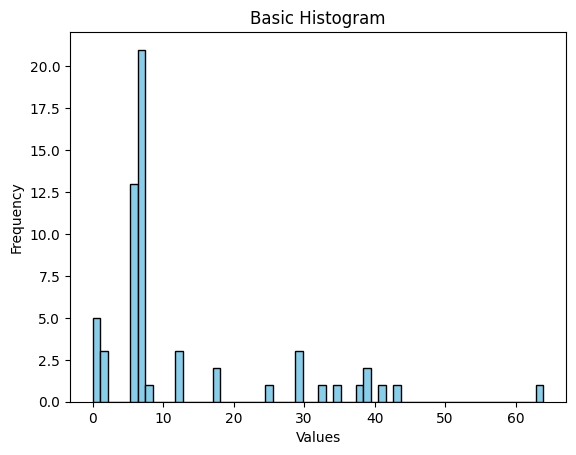

In [10]:
plt.hist(dilution, bins=len(dilution), color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')
plt.show()

In [13]:
import numpy as np

average_dilution = np.mean(dilution)
print("Average dilution:", average_dilution)


Average dilution: 12.478518656739254


In [11]:
print(dilution)

[6.5255347774416865, 0.0, 1.6149341152374308, 0.0, 6.5255347774416865, 29.35572766064083, 6.129660753996437, 6.5255347774416865, 17.07734068628394, 12.627108575764574, 25.360426398898046, 6.129660753996437, 6.5255347774416865, 0.7419338915862911, 6.5255347774416865, 35.02892621445463, 29.05310794582711, 38.7829629396533, 41.45333457383578, 6.5255347774416865, 6.129660753996437, 6.129660753996437, 17.07734068628394, 6.5255347774416865, 6.129660753996437, 6.5255347774416865, 6.5255347774416865, 12.627108575764574, 1.6149341152374308, 28.82528643283109, 6.129660753996437, 0.88604174845203, 38.54867260461583, 32.36756673208544, 6.129660753996437, 6.5255347774416865, 5.916676022809435, 2.0632230092310255, 43.08304213186778, 6.129660753996437, 63.96100686706443, 6.5255347774416865, 6.5255347774416865, 7.0839228635799545, 0.0, 12.627108575764574, 7.0839228635799545, 6.129660753996437, 38.147693487488525, 7.602291780029955, 7.0839228635799545, 6.5255347774416865, 6.5255347774416865, 6.12966075

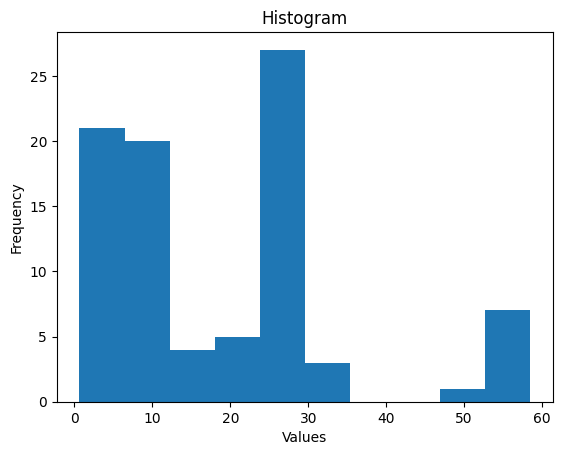

In [29]:
import matplotlib.pyplot as plt

def print_histogram(data):
    plt.hist(data)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()
print_histogram(dilution)

In [12]:

print(len(dilution))

60


27.028536808289616